In [56]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import os

print(tf.__version__)
print(os.listdir('./images'))


2.9.1
['dolphin', 'gar', 'great-white', 'grey-whale', 'hammerhead', 'sea-turtle', 'seal', 'tiger', 'train', 'whale']


In [57]:
# Constants
FAST_RUN = False
IMAGE_WIDTH=256
IMAGE_HEIGHT=256
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [58]:
# Preparing training data
filenames = os.listdir("./images/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category in ('great-white', 'hammerhead', 'tiger'):
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

<Axes: xlabel='category'>

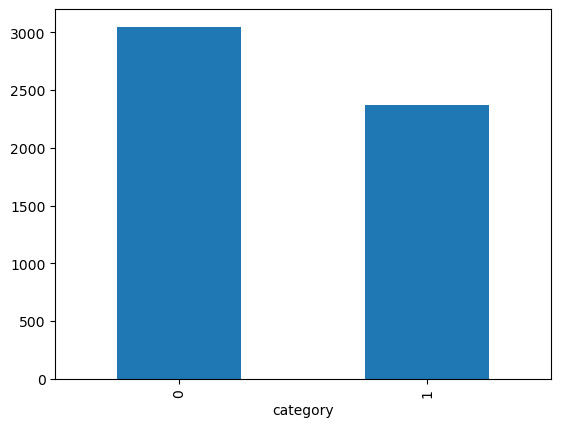

In [59]:
df['category'].value_counts().plot.bar()

hammerhead.457.jpg


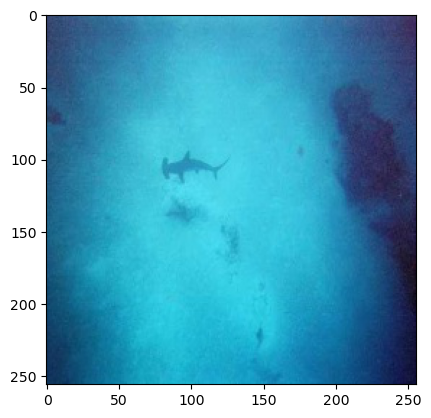

In [63]:
sample = random.choice(filenames)
print(sample)
image = load_img("./images/train/"+sample)
plt.imshow(image)

In [64]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 125, 125, 64)     2

In [65]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [66]:
earlystop = EarlyStopping(patience=10)

In [67]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [68]:
callbacks = [earlystop, learning_rate_reduction]

In [69]:
df["category"] = df["category"].replace({0: 'non-shark', 1: 'shark'}) 

In [70]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<Axes: xlabel='category'>

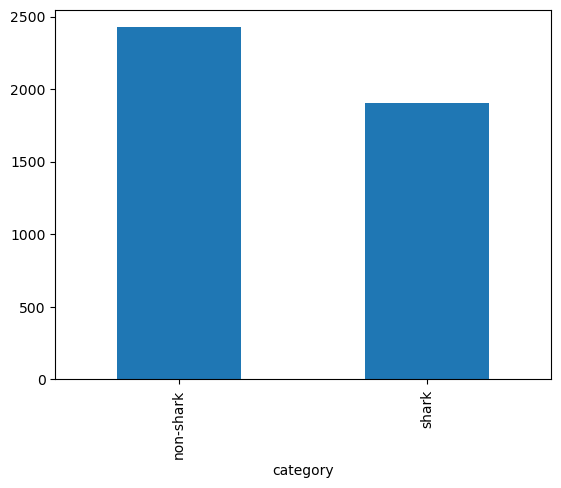

In [71]:
train_df['category'].value_counts().plot.bar()

<Axes: xlabel='category'>

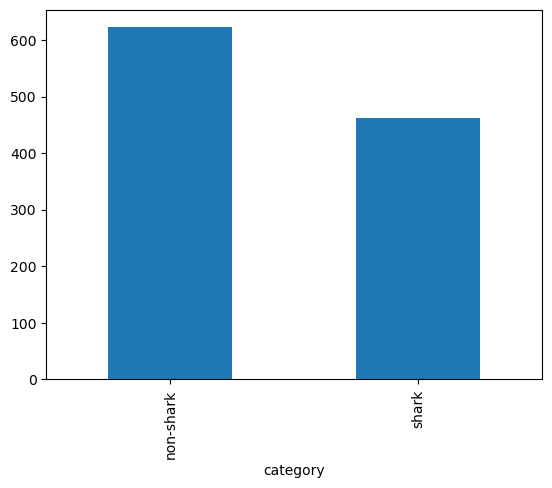

In [72]:
validate_df['category'].value_counts().plot.bar()

In [73]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [74]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./images/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 4332 validated image filenames belonging to 2 classes.


In [75]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./images/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1084 validated image filenames belonging to 2 classes.


In [76]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "./images/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


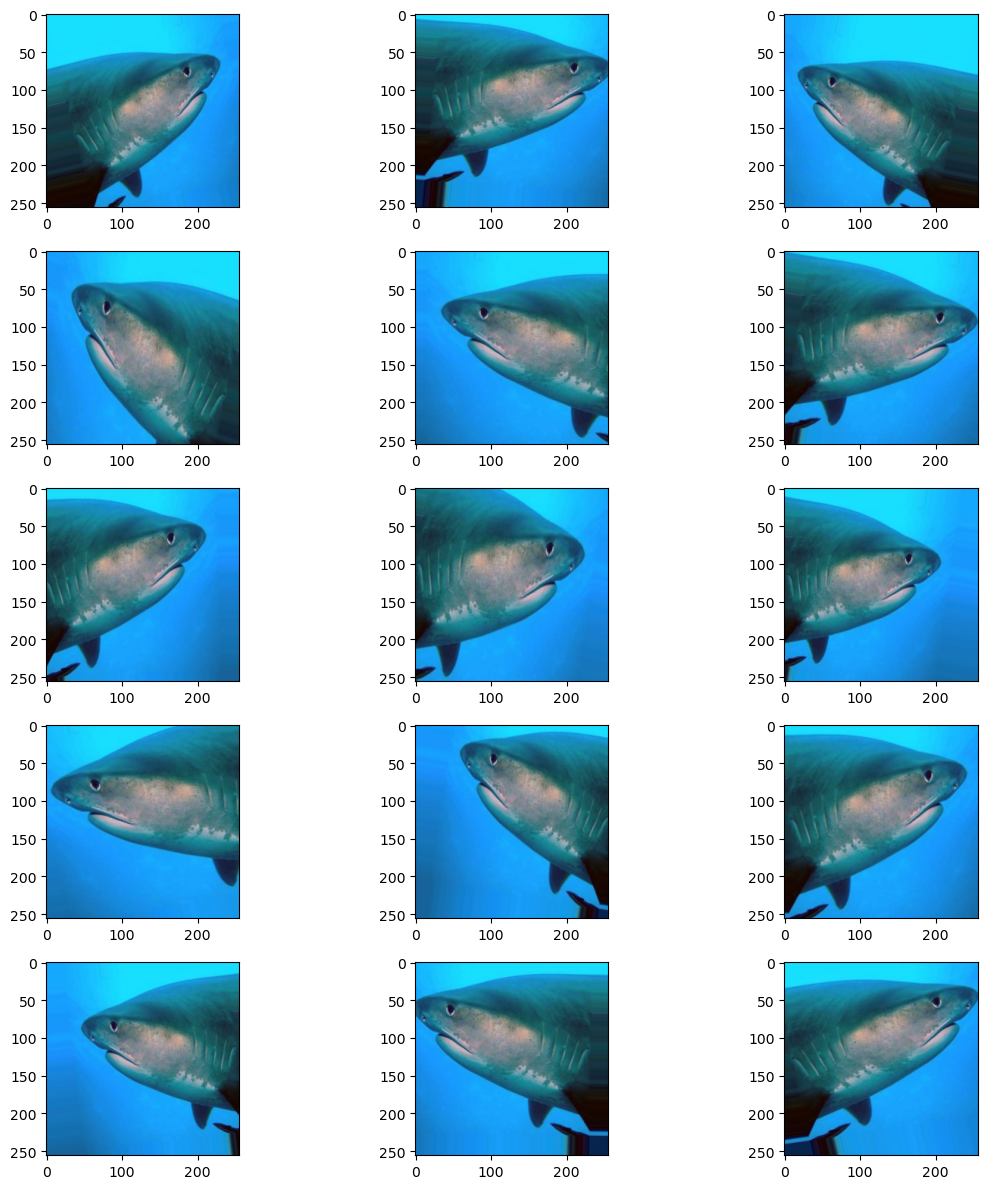

In [77]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [78]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

C:\Users\odonn\AppData\Local\Temp\ipykernel_14948\612699584.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
288/288 [==============================] - 411s 1s/step - loss: 0.8390 - accuracy: 0.6748 - val_loss: 0.7231 - val_accuracy: 0.5769 - lr: 0.0010
Epoch 2/50
288/288 [==============================] - 389s 1s/step - loss: 0.5933 - accuracy: 0.7297 - val_loss: 0.5204 - val_accuracy: 0.7537 - lr: 0.0010
Epoch 3/50
288/288 [==============================] - 412s 1s/step - loss: 0.5436 - accuracy: 0.7503 - val_loss: 0.4704 - val_accuracy: 0.7963 - lr: 0.0010
Epoch 4/50
288/288 [==============================] - 430s 1s/step - loss: 0.5258 - accuracy: 0.7614 - val_loss: 0.5246 - val_accuracy: 0.7593 - lr: 0.0010
Epoch 5/50
288/288 [==============================] - 387s 1s/step - loss: 0.5084 - accuracy: 0.7693 - val_loss: 0.8746 - val_accuracy: 0.7028 - lr: 0.0010
Epoch 6/50
288/288 [==============================] - 385s 1s/step - loss: 0.4981 - accuracy: 0.7762 - val_loss: 0.7384 - val_accuracy: 0.6704 - lr: 0.0010
Epoch 7/50
288/288 [==============================] - 391s 1s/st

In [79]:
model.save_weights("model.h5")

In [80]:
model.load_weights("model.h5")
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])